# stata

> Simple wrappers for `pystata`/`sfi` functionality
- order: 2

`sfi` is [Stata's python API](https://www.stata.com/python/api17/index.html), originally intended for interacting with Stata from python *within Stata*. As such, it can only be imported with Stata running.
`pystata.stata.run` [enables running Stata code from python](https://www.stata.com/python/pystata/stata.html#pystata.stata.run).

For one thing, using wrappers removes the need to constantly import `pystata` and/or `sfi` within functions elsewhere to avoid running afoul of CI tests in an environment without Stata installed.

In [ ]:
#| default_exp stata
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from nbstata.misc_utils import DivertedPrints, print_red

In [ ]:
#| hide
from nbstata.config import launch_stata
from nbstata.misc_utils import Timer
from textwrap import dedent
from fastcore.test import ExceptionExpected

In [ ]:
#| export
def run_direct(cmds, quietly=False, echo=False, inline=True):
    import pystata
    if quietly:
        with DivertedPrints() as diverted: # to prevent blank line output, as with `program define`
            out = pystata.stata.run(cmds, quietly, echo, inline)
            prints = diverted.getvalue()
        for line in prints.splitlines():
            if line.strip():
                print(line)
        return out
    else:
        return pystata.stata.run(cmds, quietly, echo, inline)

[https://www.stata.com/python/pystata/stata.html#pystata.stata.run](https://www.stata.com/python/pystata/stata.html#pystata.stata.run)

In [ ]:
#| hide
#| eval: False
launch_stata(splash=False)
import pystata
prog_code = "program define _temp_prog \n disp 1 \n end"
pystata.stata.run(prog_code, quietly=True)

In [ ]:
#| hide
#| eval: False
pystata.stata.run("capture program drop _temp_prog", quietly=True)
run_direct(prog_code, quietly=True)

In [ ]:
#| hide
#| eval: False
code = dedent('''\
    python:
    print("hello")
    end
    ''')
run_direct(code, quietly=True)

hello


In [ ]:
#| hide
#| eval: False
code = dedent('''\
    python:
    do_nothin = 3
    end
    ''')
run_direct(code, quietly=True)

In [ ]:
#| export
def run_single(cmd, echo=False, show_exc_warning=True):
    import sfi
    try:
        sfi.SFIToolkit.stata(cmd, echo)
    except Exception as e:
        if show_exc_warning:
            print_red(f"run_single (sfi.SFIToolkit.stata) error: {repr(e)}")
        run_direct(cmd, echo=echo)

`run_single` uses an `sfi` function for running a single command that is notably faster than `pystata.stata.run` but is less versatile and appears less resilient to errors: [https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.stata](https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.stata)

In [ ]:
#| eval: False
import sfi
with Timer():
    sfi.SFIToolkit.stata("disp 0")
with Timer():
    pystata.stata.run("disp 0")

0
Elapsed time: 0.0002 seconds
Elapsed time: 0.0227 seconds


For example, it cannot display graphs, silently quashing them instead:

In [ ]:
#| eval: False
sfi.SFIToolkit.stata("sysuse lifeexp, clear")
sfi.SFIToolkit.stata("scatter gnppc lexp")

0
(Life expectancy, 1998)


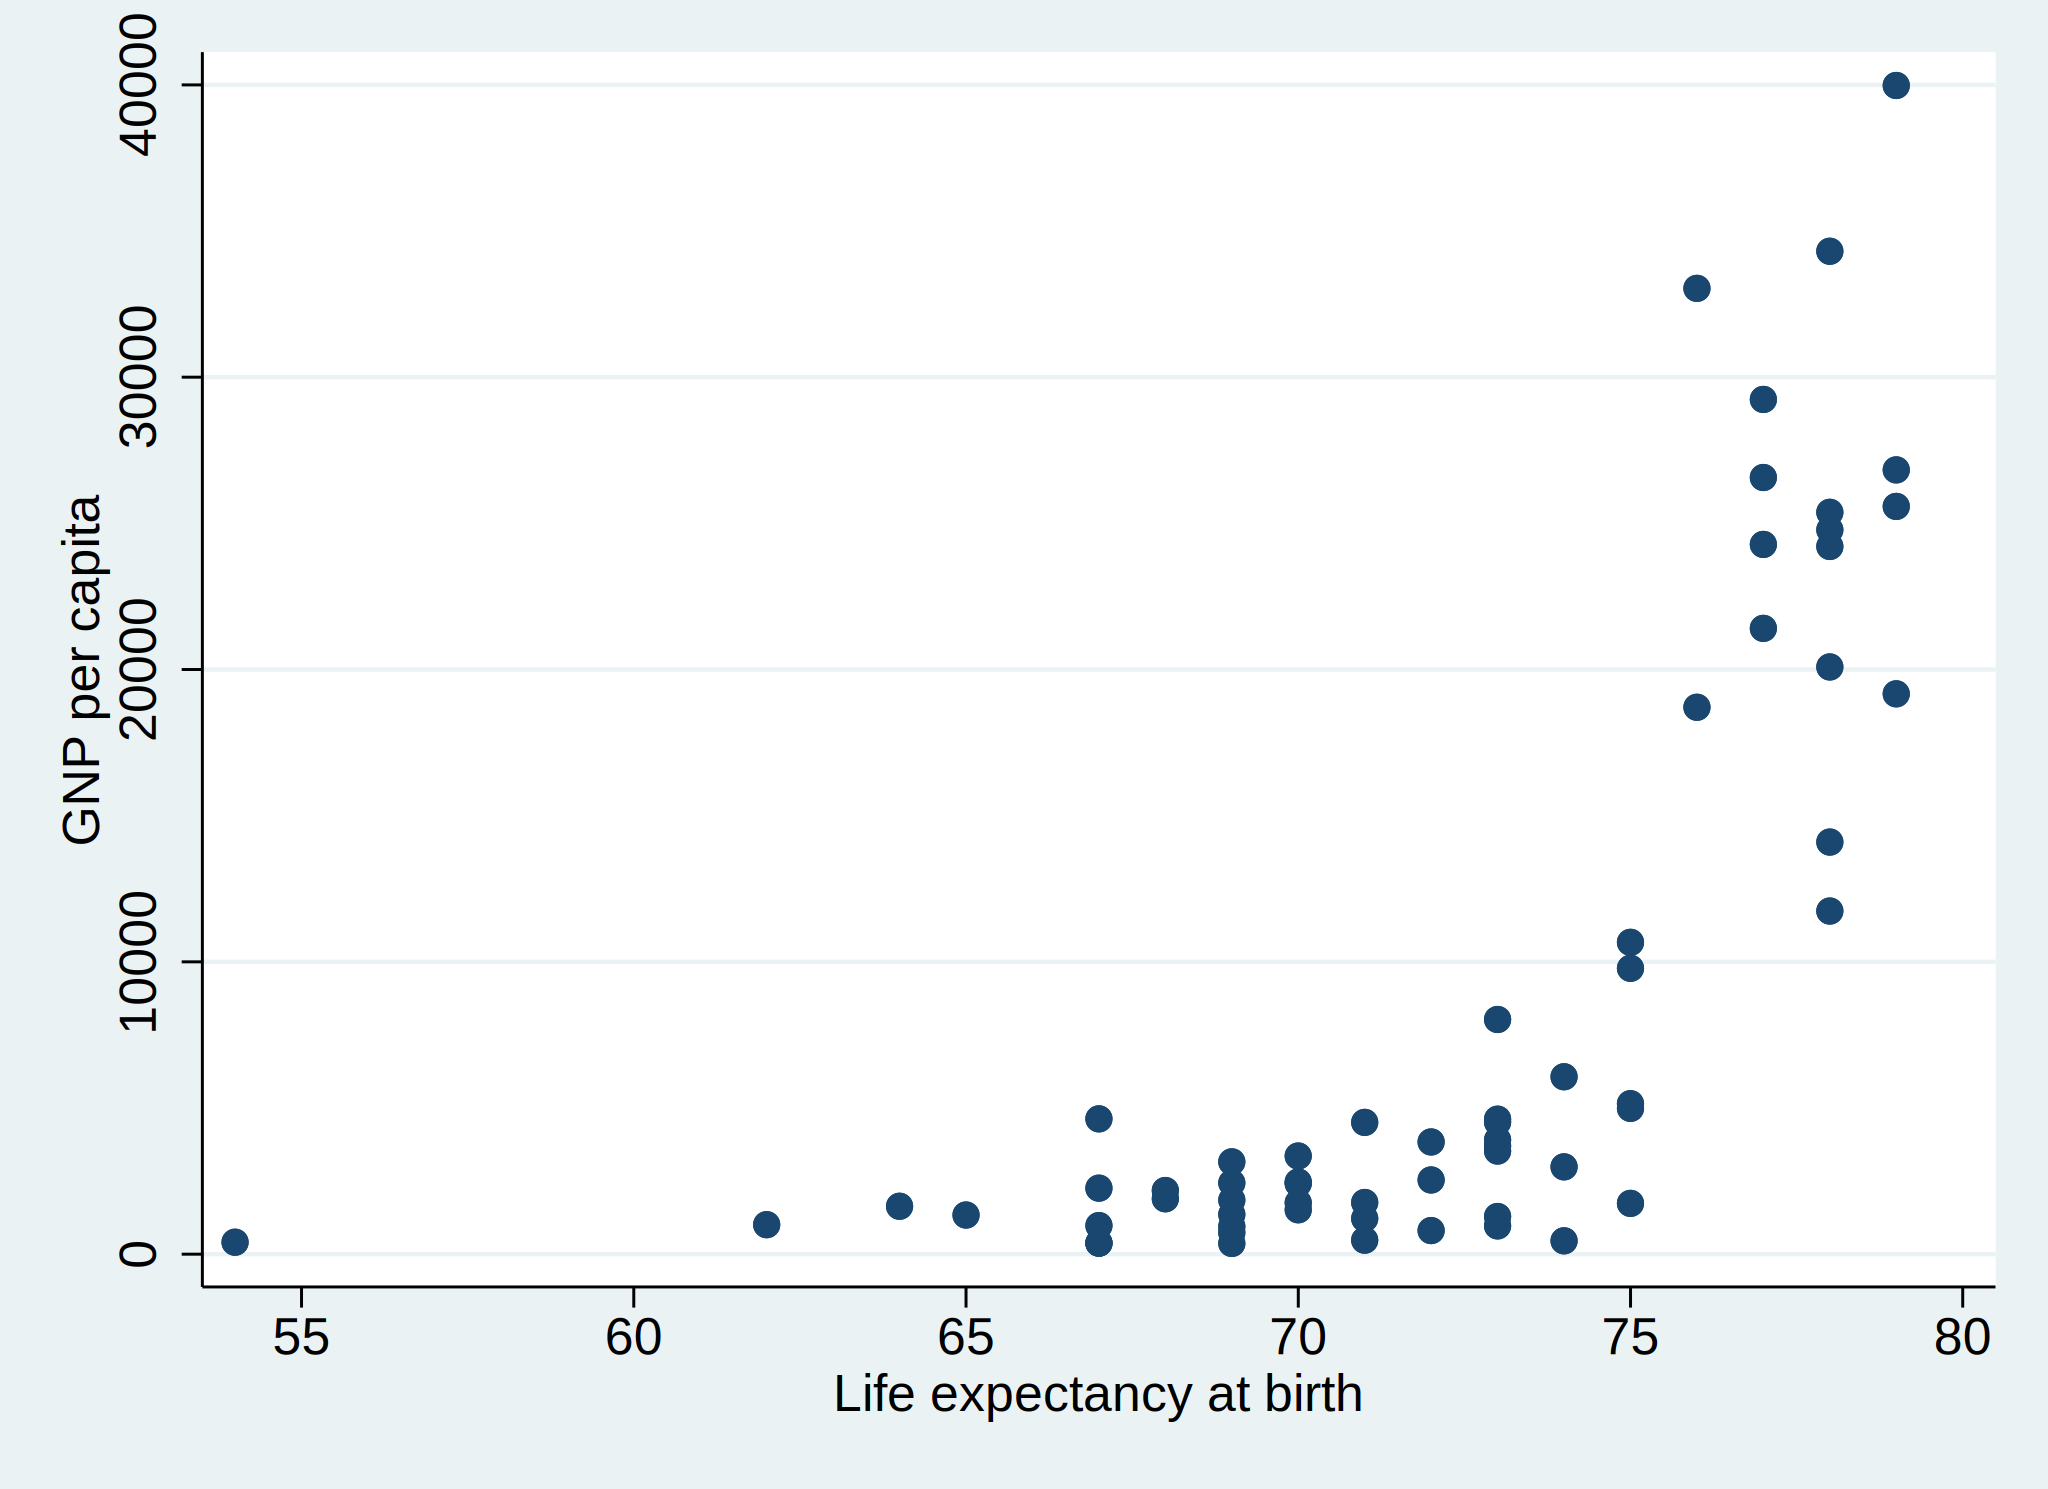

In [ ]:
#| eval: False
run_direct("scatter gnppc lexp")

In [ ]:
#| hide
#| eval: False
sfi.SFIToolkit.stata("clear")

Even worse, a subsequent run of `sfi.SFIToolkit.stata` can be affected by a previous error:

In [ ]:
#| eval: False
with ExceptionExpected(ex=SyntaxError):
    sfi.SFIToolkit.stata("disp 1 \n disp 2")

In [ ]:
#| eval: False
sfi.SFIToolkit.stata('disp "1b"')

1
 invalid name
1b


But an intervening `pystata.stata.run` execution seems to set things right.

In [ ]:
#| eval: False
try:
    sfi.SFIToolkit.stata("disp 1 \n disp 2")
except Exception:
    pystata.stata.run("disp 0")
sfi.SFIToolkit.stata('disp "1b"')

0
1b


So `run_single` should probably be used only sparingly. For when it is used, we put the above safeguard in place.

In [ ]:
#| eval: False
run_single("disp 1 \n disp 2")
run_single('disp "1b"')

run_single (sfi.SFIToolkit.stata) error: SyntaxError('failed to execute the specified Stata command')

. disp 1 
1

.  disp 2
2

. 
1b


In [ ]:
#| export
def get_local(name):
    import sfi
    return sfi.Macro.getLocal(name)

[https://www.stata.com/python/api17/Macro.html#sfi.Macro.getLocal](https://www.stata.com/python/api17/Macro.html#sfi.Macro.getLocal)

In [ ]:
#| export
def set_local(name, value):
    import sfi
    return sfi.Macro.setLocal(name, value)

[https://www.stata.com/python/api17/Macro.html#sfi.Macro.setLocal](https://www.stata.com/python/api17/Macro.html#sfi.Macro.setLocal)

In [ ]:
#| export
def get_global(name):
    import sfi
    return sfi.Macro.getGlobal(name)

[https://www.stata.com/python/api17/Macro.html#sfi.Macro.getGlobal](https://www.stata.com/python/api17/Macro.html#sfi.Macro.getGlobal)

In [ ]:
#| export
def get_scalar(name):
    import sfi
    return sfi.Scalar.getValue(name)

[https://www.stata.com/python/api17/Scalar.html?highlight=scalar#sfi.Scalar.getValue](https://www.stata.com/python/api17/Scalar.html?highlight=scalar#sfi.Scalar.getValue)

In [ ]:
#| export
def stata_formatted(value, s_format):
    import sfi
    return sfi.SFIToolkit.formatValue(value, s_format)

[https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.formatValue](https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.formatValue)

In [ ]:
#| export
def variable_names():
    from sfi import Data
    return [Data.getVarName(i) for i in range(Data.getVarCount())]

`variable_names` uses 'getVarCount' and 'getVarName': [https://www.stata.com/python/api17/Data.html](https://www.stata.com/python/api17/Data.html)

In [ ]:
#| eval: false
run_single("quietly gen var1 = 1")
variable_names()

['var1']

In [ ]:
#| export
def drop_var(name):
    import sfi
    sfi.Data.dropVar(name)

[https://www.stata.com/python/api17/Data.html#sfi.Data.dropVar](https://www.stata.com/python/api17/Data.html#sfi.Data.dropVar)

In [ ]:
#| eval: False
drop_var('var1')
variable_names()

[]

In [ ]:
#| export
def obs_count():
    """Count the number of observations"""
    import sfi
    return sfi.Data.getObsTotal()

[https://www.stata.com/python/api17/Data.html#sfi.Data.getObsTotal](https://www.stata.com/python/api17/Data.html#sfi.Data.getObsTotal)

In [ ]:
#| eval: false
obs_count()

0

In [ ]:
#| export
def pwd():
    from sfi import SFIToolkit
    return SFIToolkit.getWorkingDir()

[https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.getWorkingDir](https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.getWorkingDir)

In [ ]:
#| eval: False
pwd()[-12:]

'\\nbstata\\nbs'

#| hide
The following function is not currently used and is likely made unnecessary by `sfi.SFIToolkit.macroExpand`.

In [ ]:
#| hide
#| export
def resolve_macro(macro):
    macro = macro.strip()
    if macro.startswith("`") and macro.endswith("'"):
        macro = get_local(macro[1:-1])
    elif macro.startswith("$_"):
        macro = get_local(macro[2:])
    elif macro.startswith("${") and macro.endswith("}"):
        macro = get_global(macro[2:-1])
    elif macro.startswith("$"):
        macro = get_global(macro[1:])
    return macro

In [ ]:
#| hide
#| eval: false
run_single('global test = "hello world"')
resolve_macro("$test")

'hello world'

In [ ]:
#| hide
#| eval: false
resolve_macro("${test}")

'hello world'

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()